In [1]:
%load_ext autoreload

In [2]:
# imports
%aimport sym
%autoreload 1
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
plt.style.use('dark_background')
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
#transform = torchvision.transforms.Pad((280,280))
imagenet_data_train = torchvision.datasets.MNIST("./data/", train=True)  
imagenet_data_val = torchvision.datasets.MNIST("./data/", train=False)

In [4]:
n_digits = 9
window = (n_digits-3)//2
h_digit,w_digit = (24,8)
transform = transforms.Compose([transforms.CenterCrop((h_digit,20)),
                                transforms.Resize((h_digit,w_digit)),
                               ])
data = transform(imagenet_data_train.data)
data = data.repeat(n_digits,1,1)
mask = torch.randperm(data.shape[0])
data = data[mask].view(-1,n_digits,h_digit,w_digit) #Shuffle Data
data = data.permute(1,3,2,0).contiguous().view(w_digit*n_digits,h_digit,-1) #Concatenate digits
data = (data.permute(2,1,0).unsqueeze(1)/255)*2-1 # normalize data
targets = imagenet_data_train.targets.repeat(n_digits)
targets = targets[mask]
targets = targets.reshape(-1,n_digits)[:,window:-window].sum(axis=1)%2
#targets = 2*targets -1 
targets = targets.view(-1,1)
trainloader =torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data.float()[:-100],targets.float()[:-100]),
                                          batch_size=16,
                                          shuffle=True)

In [5]:
end = len(imagenet_data_val.data)//n_digits * n_digits
data = transform(imagenet_data_val.data[:end]).view(-1,n_digits,h_digit,w_digit) #[:-1]for 3 digits
data = data.permute(1,3,2,0).contiguous().view(w_digit*n_digits,h_digit,-1)
data = (data.permute(2,1,0).unsqueeze(1)/255)*2-1
targets = imagenet_data_val.targets[:end].view(-1,n_digits)[:,window:-window].sum(axis=1)%2 #[:-1] for 3 digits
#targets = 2*targets -1 
targets = targets.view(-1,1)
valloader =torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data.float(),targets.float()),
                                          batch_size=16,
                                          shuffle=True)

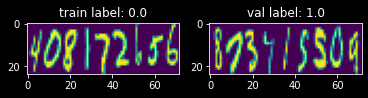

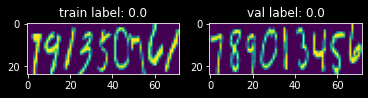

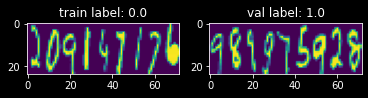

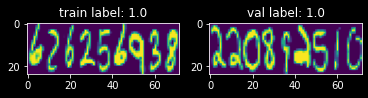

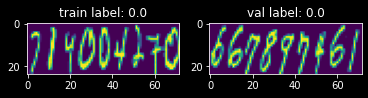

In [6]:
xs,ys =  iter(trainloader).next()
xs2,ys2 =  iter(valloader).next()
i = 0
for x,y,x2,y2 in zip(xs,ys,xs2,ys2):
    i+=1
    fig, axes = plt.subplots(1,2)
    axes[0].set_title(f"train label: {y.item()}")
    axes[1].set_title(f"val label: {y2.item()}")
    axes[0].imshow(x[0])
    axes[1].imshow(x2[0])
    if i==5: break

# Training some models 

In [7]:
T = 30  # epochs
log_step = 1  # validate and print losses every log_steps
lr = 1e-4
criterion = torch.nn.MSELoss()

In [8]:
# Define training and validation functions
def train(model, x, y):
    x = x.to(device)
    y = y.to(device)
    model.train()
    yhat = model(x)
    loss = criterion(yhat, y)
    loss.backward()
    model.optimizer.step()
    model.optimizer.zero_grad()
    return loss.item()
def validate(model, x, y):
    x = x.to(device)
    y = y.to(device)
    model.eval()
    with torch.no_grad():
        yhat = model(x)
        loss = criterion(yhat, y)
    return loss.item()
def train_loop(model, T=10, log_step=1):
    losses_train = []
    losses_val = []
    model.train()
    total_steps = len(trainloader)
    for t in range(1, T+1):
        loss = list()  # Combine losses from differetn steps in a single epoch
        # Training Step
        for step, (x, y) in enumerate(trainloader):
            loss_ = train(model, x, y)
            loss.append(loss_)
            print(
                f"Epoch {t:>03d}/{T:^3d} [Step {step+1}/{total_steps}] | Training loss: {loss_:^.4f}", end="\r")
        losses_train.append(loss)
        loss = np.mean(loss)
        # Validation Step
        if t % log_step == 0:
            message = f"Epoch {t:>03d}/{T:^3d} | Training loss: {loss:^.4f} - "
            loss = []
            with torch.no_grad():
                for x, y in valloader:
                    loss_ = validate(model, x, y)
                    loss.append(loss_)
            loss = np.mean(loss)
            losses_val.append(loss)
            message += f"Validation loss: {loss:^.4f}"
            print(message)  # ,end="\r"
    return np.concatenate(losses_train), losses_val

#  CNN Training

In [9]:
# Train the CNN 
nfilters = 1024
stride=8
kernel_size = 24
hidden = 1024
outdim = int(np.floor((h_digit*n_digits - kernel_size)/stride) + 1)
cnn = sym.models.CNN(1, out_channels=1, h=h_digit, w=w_digit*n_digits, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=torch.nn.Sigmoid())
cnn.to(device)
cnn.optimizer = torch.optim.Adam(cnn.parameters(),lr=lr)
losses_train_cnn, losses_val_cnn = train_loop(cnn,T=T,log_step=log_step)

Epoch 001/30  | Training loss: 0.2506 - Validation loss: 0.2502
Epoch 002/30  | Training loss: 0.2470 - Validation loss: 0.2225
Epoch 003/30  | Training loss: 0.1901 - Validation loss: 0.1478
Epoch 004/30  | Training loss: 0.1170 - Validation loss: 0.1000
Epoch 005/30  | Training loss: 0.0762 - Validation loss: 0.0864
Epoch 006/30  | Training loss: 0.0529 - Validation loss: 0.0863
Epoch 007/30  | Training loss: 0.0363 - Validation loss: 0.0739
Epoch 008/30  | Training loss: 0.0257 - Validation loss: 0.0763
Epoch 009/30  | Training loss: 0.0194 - Validation loss: 0.0797
Epoch 010/30  | Training loss: 0.0148 - Validation loss: 0.0800
Epoch 011/30  | Training loss: 0.0127 - Validation loss: 0.0801
Epoch 012/30  | Training loss: 0.0112 - Validation loss: 0.0760
Epoch 013/30  | Training loss: 0.0099 - Validation loss: 0.0757
Epoch 014/30  | Training loss: 0.0093 - Validation loss: 0.0856
Epoch 015/30  | Training loss: 0.0088 - Validation loss: 0.0798
Epoch 016/30  | Training loss: 0.0082 - 

In [10]:
# Define metrics function
def metrics(model):
    with torch.no_grad():
        model.eval()
        model.to(device)
        yhat = []
        targets = []
        for x, y in valloader:
            x = x.to(device)
            yhat.append(model(x).cpu().numpy())
            targets.append(y.cpu().numpy())
    yhat = np.concatenate(yhat).reshape(-1)>.5
    targets = np.concatenate(targets).reshape(-1)
    out = classification_report(yhat.astype(int),targets.astype(int))
    print(out)
    return 
def plot_loss(losses_train,losses_val,smoothing=None):
    if smoothing is None: 
        y = losses_train.reshape(-1,T).mean(axis=0)
    else:
        y = np.convolve(np.ones(smoothing)/smoothing,losses_train)
    plt.plot(np.linspace(0,T,len(y)),
             y, label="Train")
    plt.plot(np.arange(0, T, log_step), losses_val, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

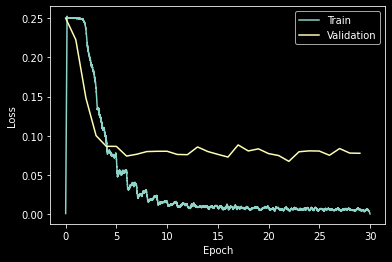

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       555
           1       0.90      0.91      0.91       556

    accuracy                           0.91      1111
   macro avg       0.91      0.91      0.91      1111
weighted avg       0.91      0.91      0.91      1111



In [11]:
plot_loss(losses_train_cnn, losses_val_cnn,smoothing=500)
metrics(cnn)

# LCN Training

In [12]:
# Train the lcn for 100 epochs
outdim = int(np.floor((h_digit*n_digits - kernel_size)/stride) + 1)
lcn = sym.models.LCN(1, out_channels=1, h=h_digit, w=w_digit*n_digits, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=torch.nn.Sigmoid())
lcn.to(device)
lcn.optimizer = torch.optim.Adam(lcn.parameters(),lr=lr)
losses_train_lcn, losses_val_lcn = train_loop(lcn,T=T,log_step=log_step)

Epoch 001/30  | Training loss: 0.2506 - Validation loss: 0.2500
Epoch 002/30  | Training loss: 0.2495 - Validation loss: 0.2436
Epoch 003/30  | Training loss: 0.2191 - Validation loss: 0.1880
Epoch 004/30  | Training loss: 0.1575 - Validation loss: 0.1252
Epoch 005/30  | Training loss: 0.1049 - Validation loss: 0.1101
Epoch 006/30  | Training loss: 0.0756 - Validation loss: 0.1072
Epoch 007/30  | Training loss: 0.0545 - Validation loss: 0.1017
Epoch 008/30  | Training loss: 0.0397 - Validation loss: 0.0903
Epoch 009/30  | Training loss: 0.0303 - Validation loss: 0.1009
Epoch 010/30  | Training loss: 0.0233 - Validation loss: 0.0980
Epoch 011/30  | Training loss: 0.0197 - Validation loss: 0.0955
Epoch 012/30  | Training loss: 0.0166 - Validation loss: 0.0942
Epoch 013/30  | Training loss: 0.0150 - Validation loss: 0.1008
Epoch 014/30  | Training loss: 0.0142 - Validation loss: 0.1100
Epoch 015/30  | Training loss: 0.0130 - Validation loss: 0.1044
Epoch 016/30  | Training loss: 0.0121 - 

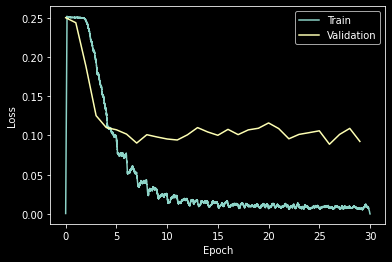

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       552
           1       0.89      0.90      0.89       559

    accuracy                           0.89      1111
   macro avg       0.89      0.89      0.89      1111
weighted avg       0.89      0.89      0.89      1111



In [13]:
plot_loss(losses_train_lcn, losses_val_lcn,smoothing=500)
metrics(lcn)

In [14]:
# for x,y in iter(valloader):
#         x = data[-30:]
#         y = targets[-30:]
#         x = x.to(device)
#         y = y.to(device)
#         cnn.eval()
#         with torch.no_grad():
#             yhat = cnn(x)
#             loss = criterion(yhat, y)
# print((yhat>.5).cpu().numpy().astype(int).flatten())
# print(y.cpu().numpy().astype(int).flatten())

# FCN Training

In [15]:
fcn = torch.nn.Sequential(torch.nn.Flatten(),
                          torch.nn.Linear(h_digit*w_digit*n_digits, nfilters), #* more for full fcn width
                          #torch.nn.BatchNorm1d(nfilters),
                          torch.nn.ReLU(),
                          torch.nn.Linear(nfilters,hidden),
                          torch.nn.ReLU(),
                          torch.nn.Linear(hidden, 1),
                          torch.nn.Sigmoid(),)
fcn.to(device)
fcn.optimizer = torch.optim.Adam(fcn.parameters(), lr=lr)
losses_train_fcn, losses_val_fcn = train_loop(fcn, T=T, log_step=log_step)

Epoch 001/30  | Training loss: 0.2506 - Validation loss: 0.2502
Epoch 002/30  | Training loss: 0.2502 - Validation loss: 0.2502
Epoch 003/30  | Training loss: 0.2500 - Validation loss: 0.2505
Epoch 004/30  | Training loss: 0.2497 - Validation loss: 0.2502
Epoch 005/30  | Training loss: 0.2490 - Validation loss: 0.2509
Epoch 006/30  | Training loss: 0.2461 - Validation loss: 0.2549
Epoch 007/30  | Training loss: 0.2363 - Validation loss: 0.2539
Epoch 008/30  | Training loss: 0.2196 - Validation loss: 0.2561
Epoch 009/30  | Training loss: 0.1985 - Validation loss: 0.2394
Epoch 010/30  | Training loss: 0.1778 - Validation loss: 0.2421
Epoch 011/30  | Training loss: 0.1583 - Validation loss: 0.2485
Epoch 012/30  | Training loss: 0.1402 - Validation loss: 0.2620
Epoch 013/30  | Training loss: 0.1225 - Validation loss: 0.2533
Epoch 014/30  | Training loss: 0.1071 - Validation loss: 0.2666
Epoch 015/30  | Training loss: 0.0936 - Validation loss: 0.2806
Epoch 016/30  | Training loss: 0.0833 - 

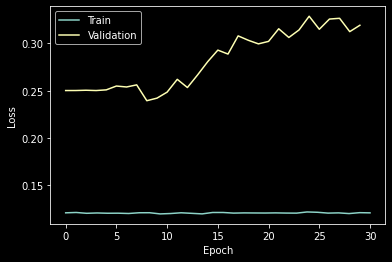

              precision    recall  f1-score   support

           0       0.62      0.63      0.63       544
           1       0.64      0.63      0.64       567

    accuracy                           0.63      1111
   macro avg       0.63      0.63      0.63      1111
weighted avg       0.63      0.63      0.63      1111



In [16]:
plot_loss(losses_train_fcn, losses_val_fcn)
metrics(fcn)

lcn


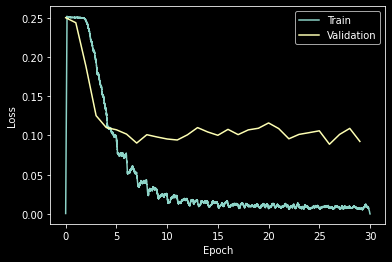

cnn


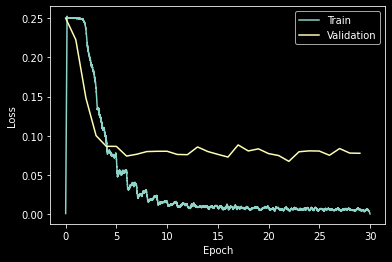

In [18]:
print("lcn")
plot_loss(losses_train_lcn, losses_val_lcn,smoothing=500)
print("cnn")
plot_loss(losses_train_cnn, losses_val_cnn,smoothing=500)

In [ ]:
cnn.conv_block1.COn